### Predictor Features
- fl_date
- mkt_unique_carrier
- branded_code_share
- mkt_carrier
- mkt_carrier_fl_num
- op_unique_carrier
- tail_num
- op_carrier_fl_num
- origin_airport_id
- origin
- origin_city_name
- dest_airport_id
- dest
- dest_city_name
- crs_dep_time
- crs_arr_time
- dup
- crs_elapsed_time
- flights
- distance

### Target Variable
- arr_delay

Machine Learning
In this file, instructions how to approach the challenge can be found.

# We are going to work on different types of Machine Learning problems:

Regression Problem: The goal is to predict delay of flights.
(Stretch) Multiclass Classification: If the plane was delayed, we will predict what type of delay it is (will be).
(Stretch) Binary Classification: The goal is to predict if the flight will be cancelled.

In [265]:
current_path = os.getcwd()

The target variable is ARR_DELAY. We need to be careful which columns to use and which don't. For example, DEP_DELAY is going to be the perfect predictor, but we can't use it because in real-life scenario, we want to predict the delay before the flight takes of --> We can use average delay from earlier days but not the one from the actual flight we predict.

For example, variables CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY shouldn't be used directly as predictors as well. However, we can create various transformations from earlier values.

We will be evaluating your models by predicting the ARR_DELAY for all flights 1 week in advance.

In [810]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn import metrics
from sklearn.metrics import recall_score, precision_score, r2_score
import xgboost as xgb
import pickle
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder, PolynomialFeatures, MinMaxScaler, OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
import warnings
import os
from datetime import datetime
from sklearn.linear_model import Ridge

warnings.filterwarnings("ignore")


In [770]:
df = pd.read_csv('/Users/arjunduggal/Desktop/lighthouse-data-notes/Midterm_1/Data/FLIGHTS_cleaned.csv')

In [771]:
model_df = df[['arr_delay','dep_delay','fl_date','op_unique_carrier','origin','dest',
               'crs_dep_time','crs_arr_time','flights','crs_elapsed_time','distance','origin_city_name',
               'dest_city_name','origin_airport_id','dest_airport_id']]

In [772]:
def fill_na(df):'''Simple function to replace empty entries with place holder of 0'''
for i in delay_list:
    df[i] = df[i].fillna(0)

### Replacing any potential null elapsed time values with place holder of 0 (reduces chance of any bias influecing a key feature in our model)


In [773]:
model_df['crs_elapsed_time'] = model_df['crs_elapsed_time'].fillna(0)
df['arr_delay'] = df['arr_delay'].fillna(0)

### Simply check whether there is a arrival delay or not through a binary value


In [774]:
if 'arr_delay' in model_df.columns:
    model_df['delay_occured'] = model_df['arr_delay'].map(lambda x: 0 if x <= 0 else 1)
    #model_df.drop(columns='arr_delay', inplace=True)

### Converting datetime feature from yy-mm-dd in order to grab the specific month, day of the week. Strong relationship between what day of the week it is and how much air traffic ensues


In [775]:
month_to_season = {1: 1, 2: 1, 3: 2, 4: 2, 5: 2, 6: 3, 7: 3, 8: 3, 9: 4, 10: 4, 11: 4, 12: 1}
model_df['fl_date'] = pd.to_datetime(model_df['fl_date'], errors='coerce')
model_df['month'] = model_df['fl_date'].dt.month
model_df['day_of_week'] = model_df['fl_date'].dt.dayofweek
model_df['day_of_month'] = model_df['fl_date'].dt.day
model_df['year'] = model_df['fl_date'].dt.year
model_df['season'] = model_df['month'].map(month_to_season)
#model_df.drop(columns=['fl_date'],inplace=True)

### Categorzining the kind of flight that endured based on the crs_elapsed_time feature, doing so as we believe longer flights tend to generate a greater arrival delay then others

In [776]:
#encoding function to numerical describe the duration of a flight based on three intervals (less than 3 hours, in between 3-6 hours and greater then 6 hours)
def time_cat(df, col):
    '''Determine if flight length is SHORT (0), MEDIUM(1) or LONG(2) based on expected elapsed flight time. '''
    length=[]
    for i in df[col]:
        if i < (3*60): # up to 3 hours
            length.append(0) # 0 = SHORT 
        elif (i >= (3*60)) and (i < (6*60)): # 3-6 hours
            length.append(1) # 1 = MEDIUM 
        elif i >= (6*60):# 6+ hours
            length.append(2) # 2 = LONG 

    df['time_cat'] = length

In [777]:
time_cat(model_df,'crs_elapsed_time')

In [778]:
model_df.time_cat.value_counts()

0    156229
1     37436
2      2890
Name: time_cat, dtype: int64

### Distance/ crs_elapsed_time, unsure if we'll be privied to this sort of information?


In [779]:
def avg_plane_velo(df,distance,time):
    '''Creating a basic function derived from kinematics that takes in airtime (minutes) and distance(miles) 
    to return the average plane velocity, want the si unit to be in Mph'''
    
    df['avg_plane_velocity'] = df[distance] / df[time] * 60 

In [780]:
avg_plane_velo(model_df,'distance','crs_elapsed_time')

### Converting to Milatary time, longer process is to create categorical time of day information using time_day function defined below as well as expected delays relating to the time of day departure

In [781]:
def time_row(row):
    row_int = int(row)
    row_str = str(row_int)
    len_row = len(row_str)
    if len_row ==1:
        minute = "00"
        hour = row_str
        row = hour+minute
    if len_row ==2:
        minute = '0' +row_str[1]
        hour = row_str[0]
        row = hour + minute
    elif len_row ==4:
        minute = row_str[2] +row_str[3]
        hour = row_str[0] + row_str[1]
        row = hour + minute
        if row =='24:00':
            row ='23:59'
    return str(row)

In [782]:
model_df['dep_time_milatary'] = model_df['crs_dep_time'].apply(time_row)

In [783]:
model_df['arr_time_milatary'] = model_df['crs_arr_time'].apply(time_row)

### crs_elapsed_time --> haul_length


In [784]:
def time_day(df,col,new_col):
    lst=[]
    for i in df[col]:
        if ((len(i)==4) and (int(i[:2]) >=23)) or ((len(i)==3) and (int(i[0]) < 5)):
            lst.append(0) # 0 = OVERNIGHT
        elif ((len(i) == 3) and (int(i[0])>=5)) or ((len(i)==4) and (int(i[:2]) < 12)):
            lst.append(1) # 1 = MORNING
        elif (len(i)==4) and (int(i[:2]) >= 12) and (int(i[:2]) < 18):
            lst.append(2) # 2 = AFTERNOON
        elif (len(i)==4) and (int(i[:2])>=18) and (int(i[:2])<23):
            lst.append(3) # 3 = EVENING
    
    print(len(lst))
    df[[new_col]] = lst
    
    return df[[new_col]]

In [785]:
time_day(model_df,'dep_time_milatary','dep_time_haul')

196555


,dep_time_haul
0,2
1,1
2,2
3,2
4,1
...,...
196550,1
196551,1
196552,1
196553,3


In [786]:
time_day(model_df,'arr_time_milatary','arr_time_haul')

196555


,arr_time_haul
0,3
1,3
2,0
3,3
4,1
...,...
196550,2
196551,1
196552,1
196553,3


### Origin and Arrival state Columms

In [787]:
model_df['origin_state'] = model_df['origin_city_name'].str[-2:]

In [788]:
model_df['dest_state']= model_df['dest_city_name'].str[-2:]

### Summary statistics for aiports based on arrival and depature locations

In [789]:
model_df['origin_airport_volume'] = model_df.groupby(['origin_airport_id'])['flights'].transform(np.sum) 

In [790]:
model_df['dest_aiport_volume'] =model_df.groupby(['dest_airport_id'])['flights'].transform(np.sum)

In [791]:
model_df['carrier_origin_apt_vol'] = model_df.groupby(['origin_airport_id','op_unique_carrier'])['flights'].transform(np.sum)
model_df['carrier_dest_apt_vol'] = model_df.groupby(['dest_airport_id','op_unique_carrier'])['flights'].transform(np.sum)

In [792]:
model_df['carrier_origin_apt_pct'] = model_df['carrier_origin_apt_vol'] / model_df['origin_airport_volume'] * 100
model_df['carrier_dest_apt_pct'] = model_df['carrier_dest_apt_vol'] / model_df['dest_aiport_volume'] * 100

In [793]:
model_df['mean_carrier_arr_delay'] = model_df.groupby(['op_unique_carrier','month'])['arr_delay'].transform(np.mean)
model_df['mean_carrier_dep_delay'] = model_df.groupby(['op_unique_carrier','month'])['dep_delay'].transform(np.mean)

In [794]:
model_df

,arr_delay,dep_delay,fl_date,op_unique_carrier,origin,dest,crs_dep_time,crs_arr_time,flights,crs_elapsed_time,...,origin_state,dest_state,origin_airport_volume,dest_aiport_volume,carrier_origin_apt_vol,carrier_dest_apt_vol,carrier_origin_apt_pct,carrier_dest_apt_pct,mean_carrier_arr_delay,mean_carrier_dep_delay
0,72.0,72.0,2019-03-18,AA,DFW,RSW,1454,1821,1.0,147.0,...,TX,FL,7097.0,873.0,3647.0,111.0,51.387910,12.714777,3.774210,9.466356
1,23.0,30.0,2019-06-19,AA,SAN,CLT,1058,1850,1.0,292.0,...,CA,NC,2412.0,6209.0,225.0,2472.0,9.328358,39.813174,12.272488,16.439037
2,-19.0,-5.0,2018-10-23,UA,DEN,BWI,1750,2312,1.0,202.0,...,CO,MD,6797.0,2602.0,1611.0,94.0,23.701633,3.612606,2.155639,5.813953
3,26.0,36.0,2018-09-07,WN,LAS,OAK,1720,1850,1.0,90.0,...,NV,CA,4142.0,1337.0,1809.0,1036.0,43.674553,77.486911,-1.644198,5.766234
4,-11.0,-5.0,2018-11-04,OO,LAX,SAN,733,828,1.0,55.0,...,CA,CA,6162.0,2435.0,817.0,220.0,13.258682,9.034908,2.425584,7.480416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196550,-4.0,-5.0,2019-07-30,WN,SJC,AUS,735,1305,1.0,210.0,...,CA,TX,1639.0,1618.0,821.0,606.0,50.091519,37.453646,6.291638,13.244753
196551,1.0,0.0,2019-04-10,G4,PIE,GSP,640,809,1.0,89.0,...,FL,SC,194.0,394.0,194.0,7.0,100.000000,1.776650,5.829493,7.206422
196552,-1.0,-6.0,2019-03-21,AX,HDN,DEN,840,947,1.0,67.0,...,CO,CO,35.0,6825.0,10.0,553.0,28.571429,8.102564,9.159722,12.179310
196553,51.0,71.0,2018-11-19,UA,ORD,SNA,1935,2200,1.0,265.0,...,IL,CA,9654.0,1100.0,1931.0,148.0,20.002072,13.454545,4.774797,8.357895


### Changing to category dtype to use a nice encoding process that won't increase the dimensionality of our Df (unsure if we can then use a standard scaler effectively use this encoding method)


In [795]:
for i in ['op_unique_carrier','origin','dest','origin_state','dest_state']:
    model_df[[i]] = model_df[[i]].astype('category')

In [796]:
model_df['op_unique_carrier'] = model_df.op_unique_carrier.cat.codes
model_df['origin'] = model_df.origin.cat.codes
model_df['dest'] = model_df.dest.cat.codes
model_df['origin_state'] = model_df.origin_state.cat.codes
model_df['dest_state'] = model_df.dest_state.cat.codes

### Final Examination Of Data Prior to Modelling

In [797]:
model_df.drop(columns=['crs_dep_time','crs_arr_time','origin_city_name','dest_city_name','dep_time_milatary','arr_time_milatary','fl_date','arr_delay','dep_delay'],inplace=True,axis=1)
model_df.dtypes

op_unique_carrier            int8
origin                      int16
dest                        int16
flights                   float64
crs_elapsed_time          float64
distance                  float64
origin_airport_id           int64
dest_airport_id             int64
delay_occured               int64
month                       int64
day_of_week                 int64
day_of_month                int64
year                        int64
season                      int64
time_cat                    int64
avg_plane_velocity        float64
dep_time_haul               int64
arr_time_haul               int64
origin_state                 int8
dest_state                   int8
origin_airport_volume     float64
dest_aiport_volume        float64
carrier_origin_apt_vol    float64
carrier_dest_apt_vol      float64
carrier_origin_apt_pct    float64
carrier_dest_apt_pct      float64
mean_carrier_arr_delay    float64
mean_carrier_dep_delay    float64
dtype: object

In [798]:
print(df[['arr_delay']].isnull().any())
total = model_df.isnull().sum().sort_values(ascending=False)
percent = (model_df.isnull().sum()/model_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['total', 'percent'])
missing_data

arr_delay    False
dtype: bool


,total,percent
mean_carrier_dep_delay,0,0.0
mean_carrier_arr_delay,0,0.0
origin,0,0.0
dest,0,0.0
flights,0,0.0
crs_elapsed_time,0,0.0
distance,0,0.0
origin_airport_id,0,0.0
dest_airport_id,0,0.0
delay_occured,0,0.0


### Scaling Process (standard scaler), sidenote should we scale the target or no?

In [799]:
from sklearn import preprocessing
ss = preprocessing.StandardScaler()
df_train_scaled = pd.DataFrame(ss.fit_transform(model_df),columns = model_df.columns)
df_target_scaled = pd.DataFrame(ss.fit_transform(df[['arr_delay']]))

In [800]:
X = df_train_scaled 
y = df_target_scaled 

In [801]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8, random_state=123)

### PCA

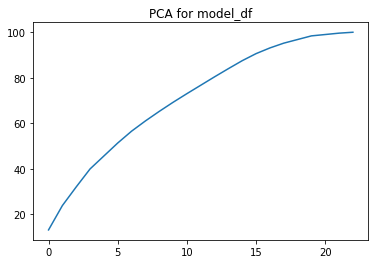

In [820]:
from sklearn.decomposition import PCA #pca may not be optimal in this case
pca =PCA(n_components=23)
X_train= pd.DataFrame(pca.fit_transform(X_train))
X_test = pd.DataFrame(pca.fit_transform(X_test))

plt.plot(np.cumsum(np.round(pca.explained_variance_ratio_,decimals =3)*100))
plt.title('PCA for model_df')
plt.show()

### Linear Regression

In [821]:
lr_model = LinearRegression()
lr_model.fit(X_train,y_train)
lin_pred = lr_model.predict(X_test)

In [822]:
kfold = KFold(n_splits=10, random_state=7, shuffle=True)
scoring = 'r2'
results = cross_val_score(lr_model, X_train, y_train, cv=kfold, scoring=scoring)
print("R^2: %.3f (%.3f)" % (results.mean(), results.std()))

R^2: 0.259 (0.019)


In [823]:
print('Coefficient of determination: %.2f'
      % r2_score(y_test,lin_pred))

Coefficient of determination: -0.41


In [824]:
metrics.mean_squared_error(y_test,lin_pred)

1.2771450604184331

In [825]:
metrics.r2_score(y_test,lin_pred) #? pca significantly reduced this lol

-0.407604276356792

In [826]:
print(lr_model.intercept_)

[0.00266916]


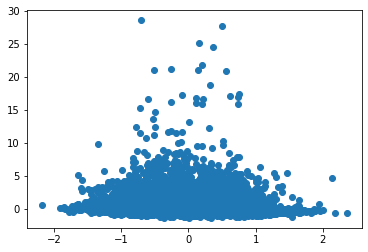

In [827]:
plt.scatter(preds,y_test)
plt.show()

### Ridge Regression

In [811]:
from sklearn.linear_model import Ridge

In [812]:
param_grid = {'alpha': [0.001,0.01,0.1,0.5]}
grid = GridSearchCV(estimator = Ridge(normalize = True), param_grid = param_grid, n_jobs=-1, verbose = 1)

In [813]:
grid.fit(X_train,y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(estimator=Ridge(normalize=True), n_jobs=-1,
             param_grid={'alpha': [0.001, 0.01, 0.1, 0.5]}, verbose=1)

In [814]:
grid.best_params_

{'alpha': 0.001}

In [815]:
reg = Ridge(alpha = grid.best_params_['alpha'], normalize = True)

In [816]:
reg.fit(X_train,y_train)

Ridge(alpha=0.001, normalize=True)

In [817]:
reg_pred = reg.predict(X_test)

In [818]:
metrics.mean_squared_error(y_test,reg_pred)

1.2765147725484238

In [819]:
metrics.r2_score(y_test,reg_pred)

-0.4069096051493801

### Rough Work

In [ ]:
# df_copy.merge(pd.get_dummies(df_copy.month),left_index=True, right_index=True)

In [19]:
# orgdummy = pd.get_dummies(df_copy.origin, prefix='O_') #origin category encoding 
# df_copy_train = df_copy_train.merge(destdummy,left_index=True,right_index=True)
# df_copy_train = df_copy_train.merge(orgdummy,left_index=True, right_index=True)
# df_copy_train = df_copy_train.merge(pd.get_dummies(df_copy.month),left_index=True, right_index=True)
# destdummy = pd.get_dummies(df_copy.dest, prefix='D_') #destination category encoding
# df_copy_train['mkt_unique_carrier']= df_copy_train.groupby('mkt_unique_carrier').count()/len(df_copy_train)

In [25]:
# encoder = OrdinalEncoder()
# df_copy_train['mkt_unique_carrier'] = encoder.fit_transform(df_copy_train[['mkt_unique_carrier']])

In [190]:
# count =0
# for i in range (len(df_copy_train)):
#     if df_copy_train.iloc[i].dtype == 'object':
#         count +=1 simply verifying we only have numeric data for our regression models
# print(count)

0


In [769]:
len(model_df.columns)

28

In [767]:
y_test

,0
82679,-0.467449
44120,1.033628
123281,0.193025
35163,0.293096
74445,-0.267305
...,...
155280,0.092953
26680,-0.447435
113559,-0.527492
191658,0.673369


In [461]:
preds

array([[-0.37571865],
       [ 0.71979391],
       [ 0.72071729],
       ...,
       [-0.30411733],
       [ 0.6098071 ],
       [-0.26186715]])

In [497]:
df_lr = pd.DataFrame({'Actual': y_test, 'Predicted':preds})

ValueError: If using all scalar values, you must pass an index

In [271]:
# # Cleaning Functions
# def eliminateCorrFeatures(coef_, df):
#     """
#     coef_ should be between 0 and 1
#     """
#     # step 1
#     df_corr = df.corr().abs()

#     # step 2
#     indices = np.where(df_corr > coef_) 
#     indices = [(df_corr.index[x], df_corr.columns[y]) for x, y in zip(*indices)
#                                         if x != y and x < y]

#     # step 3
#     for idx in indices: #each pair
#         try:
#             df.drop(idx[1], axis = 1, inplace=True)
#         except KeyError:
#             pass
#     return df

# from sklearn.feature_selection import VarianceThreshold
# def eliminateLowVariance(x, df):
#     """
#     x should be between 0 and 1
#     """
#     vt = VarianceThreshold(x)
#     vt.fit(df)
#     return df.loc[:, vt.variances_ > x]


# def calc_specificity(y_actual, y_pred, thresh):
#     return sum((y_pred < thresh) & (y_actual == 0)) / sum(y_actual == 0)

# def print_report(y_actual, y_pred, thresh):
#     auc = skm.roc_auc_score(y_actual, y_pred)
#     accuracy = skm.accuracy_score(y_actual, (y_pred > thresh))
#     recall = skm.recall_score(y_actual, (y_pred > thresh))
#     precision = skm.precision_score(y_actual, (y_pred > thresh))
#     specificity = calc_specificity(y_actual, y_pred, thresh)
#     print(f'AUC:{auc:%.3f}')
#     print(f'accuracy:{accuracy:%.3f}')
#     print(f'recall:{recall:%.3f}')
#     print(f'precision:{precision:%.3f}')
#     print(f'specificity:{specificity:%.3f}')
#     print(' ')
#     return auc, accuracy, recall, precision, specificity




In [270]:
#One way of encoding our categorical data
# lb = LabelBinarizer()
# lb = lb.fit(df_copy.month.tolist()) got seperate classes but once it was called to transform, didn't give the desired output(class for each month)
# lb.classes_
# df_copy['month'] = lb.transform(df_copy['month'].tolist())

# lb = LabelBinarizer()
# lb = lb.fit(df_copy_train.origin.tolist()) #got seperate classes but once it was called to transform, didn't give the desired output(class for each month)
# lb.classes_
# df = lb.transform(df_copy_train.origin.tolist()).sum()

#df_copy_train

# df_copy_train = df_copy_train.join(pd.DataFrame(lb.fit_transform(df_copy_train["origin"]),
#columns=lb.classes_, 
# index=df_copy_train.index))


#Can't use any of the delay features
# delay_list = ['dep_delay','arr_delay','carrier_delay','weather_delay','nas_delay','security_delay','late_aircraft_delay']

#
# fill_na(df_copy)
# df_copy['total_delay'] = df_copy.iloc[:,-5:].sum(axis=1)
# df_copy['is_delayed'] = df_copy.apply(lambda x: (0 if x['total_delay'] <= 0 else 1),  axis=1)
### length of flight could be another contributor, could encode a flight (SHORT MEDIUM LONG)
# 
# def haul_length(df,col):
#     for i in df[col]:
#         if i <=180:
#             df['time_cat'] = 0.0 #short
#         elif(i>180) & (i < 360):
#             df['time_cat'] = 1.0 #medium
#         else:
#             df['time_cat']= 2.0 #long
# model_df.drop(columns=['departure_cat', 'haul_hour'], axis=1, inplace=True)
# model_df.drop(columns=['time_haul'],axis=1,inplace=True)